In [32]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

from tqdm.notebook import tqdm
from torch.utils import data as torch_data

In [42]:
PATH_TO_DATA = 'D:\\SR_kspace\\data\\dl_bio'
PATH_TO_SOURCE_TRAIN = os.path.join(PATH_TO_DATA, 'ax_t2_source_train')
PATH_TO_SOURCE_VAL = 'D:\\SR_kspace\\data\\dl_bio\\ax_t2_source_val'
PATH_TO_SOURCE_TEST = 'D:\\SR_kspace\\data\\dl_bio\\ax_t2_source_test'

RANDOM_STATE = 42

LR_SIZE = (160,160)

In [34]:
def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)

In [35]:
def calculate_spec(fft):
    spectrum = 20*np.log(np.abs(fft) + 1e-9)
    return spectrum

In [39]:
class ReImSampler(torch_data.Dataset):
    def __init__(self, path_to_data, resize=None):
        super().__init__()

        self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('.npy')]
        self.resize = resize

    def __len__(self):
        return len(self.images)

    def sample_slice(self, slice):
        slice_fft = np.fft.fft2(slice)
        slice_kspace = np.fft.fftshift(slice_fft)

        fft_real = np.real(slice_kspace)
        fft_imag = np.imag(slice_kspace)
        
        tensor = np.stack((fft_real, fft_imag), axis=0).astype(np.float32)
        tensor /= tensor.max()
        
        return tensor

    def __getitem__(self, idx):
        
        slice = npy_load(self.images[idx])[0]
        if self.resize:
            slice = resize(slice, self.resize, mode='constant', preserve_range=True)

        slice_sampled = self.sample_slice(slice)

        return self.images[idx], slice_sampled

(2, 160, 160)
D:\SR_kspace\data\dl_bio\ax_t2_source_val\171317411218_6.npy


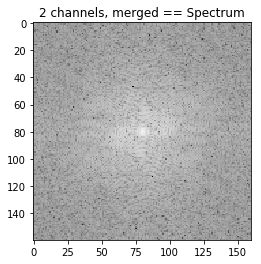

In [43]:
train_loader = ReImSampler(PATH_TO_SOURCE_VAL, LR_SIZE)

i = np.random.randint(0, len(os.listdir(PATH_TO_SOURCE_VAL)))
name, tensor = train_loader.__getitem__(i)
print(tensor.shape)
spec_2ch_tensor =  calculate_spec(tensor[0])
plt.imshow(spec_2ch_tensor, cmap='gray')
plt.title("2 channels, merged == Spectrum", fontsize=12)
print(name)
plt.show()

C:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


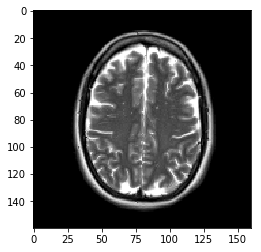

In [44]:
t = tensor[0] + 1j * tensor[1]
a = np.fft.ifftshift(t)
s = np.fft.ifft2(a)
s = np.array(s, dtype=float)
plt.imshow(s, cmap='gray')

In [47]:
samples_val = os.listdir(PATH_TO_SOURCE_VAL)
len(samples_val)

14697

In [51]:
parts = ['train', 'val', 'test']
size = LR_SIZE[0]
label = f're_im_{size}'

for part in parts:

    if part == 'train':
        path_to_sources = PATH_TO_SOURCE_TRAIN
    elif part == 'val':
        path_to_sources = PATH_TO_SOURCE_VAL
    elif part == 'test':
        path_to_sources = PATH_TO_SOURCE_TEST
    else:
        raise ValueError()

    path_to_save = os.path.join(PATH_TO_DATA, f'ax_t2_{label}_{part}/')
    print(path_to_sources, path_to_save, sep=' -> ')
    os.makedirs(path_to_save, exist_ok=True)

    for path, slice_sampled in tqdm(ReImSampler(path_to_sources, LR_SIZE)):
        name = os.path.split(path)[1]

        with open(os.path.join(path_to_save, name), 'wb') as f:
            np.save(f, slice_sampled)
#             break
            

D:\SR_kspace\data\dl_bio\ax_t2_source_train -> D:\SR_kspace\data\dl_bio\ax_t2_re_im_160_train/



D:\SR_kspace\data\dl_bio\ax_t2_source_val -> D:\SR_kspace\data\dl_bio\ax_t2_re_im_160_val/



D:\SR_kspace\data\dl_bio\ax_t2_source_test -> D:\SR_kspace\data\dl_bio\ax_t2_re_im_160_test/
